# Final Project: Machine Learning Applications
# *Goodreads meets NLP*
## Bachelor in Data Science and Engineering

<div>
<img src="attachment:9b620285-3e0e-4fe0-8bad-100ddbc27b71.png" height="300" width="300"/>
</div>

Done by:

* Alvaro Viejo Alonso (NIA: 100451677)
* Rodrigo Oliver Coimbra (NIA: 100451788)
* Héctor Tienda Cárdenas (NIA: 100)

## 0. Introduction and explanation

In this project we put in practice what was learned in the course of Machine Learning Applications on the area of Natural Language Processing (NLP). We will be analyzing a Goodreads book review dataset and we will be solving two learning tasks: regression (to predict the review score from the review text) and topic modelling (to predict the genre of the book that is being reviewed).

## 1. Data loading and preprocessing pipeline

### 1.1 Data loading

We are loading the `reviews_spoiler_reduced.csv` dataset which consists of three columns: `review_text` (string), `rating` (integer) and `book_genre` (factor).

We will be using `Dask` to apply the tokenization and lemmatization with spaCy of the dataset. This library parallelizes common Python libraries such as `Pandas` or `Numpy` and allows for better scalability, for more information check their [FAQ](https://docs.dask.org/en/stable/faq.html). According to `Dask`'s official webpage: "Dask is used within the world’s largest banks, national labs, retailers, technology companies, and government agencies".

In [1]:
%%time
# !conda install -c conda-forge spacy
# !conda install -c conda-forge cupy
# !python -m spacy download en_core_web_trf

###### DATA STORAGE & MANIPULATION ######
import pandas as pd
import dask.dataframe as dd
import dask.bag as db
import dask.config
import numpy as np
import csv


###### DATA VISUALIZATION ######
import matplotlib.pyplot as plt
import seaborn as sns

###### NLP ######
import spacy
import gensim

###### MACHINE LEARNING ######
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

###### CUML, RAPIDS ######
import cudf
import cuml

###### PARALLELIZATION ######
from joblib import parallel_backend

###### SYSTEM ######
import os
import subprocess

###### OTHERS ######
import pickle
from tqdm.auto import tqdm
from tqdm.dask import TqdmCallback
from dask.diagnostics import ProgressBar


# Create Pandas method to provide tqdm progress
tqdm.pandas()

# Use TqdCallback globally
cb = TqdmCallback(desc="global")
cb.register()

# Define DASK_WORKERS
DASK_WORKERS = os.cpu_count()*2 - 2

# Set number of dask workers
dask.config.set(num_workers=DASK_WORKERS)

# Define path where .parquet file is defined
PARQUET_FILE = "data/reviews_spoiler_full_tokenized.parquet"

CPU times: user 11.2 s, sys: 4.46 s, total: 15.7 s
Wall time: 1min 25s


In [2]:
%%time
if not os.path.exists(PARQUET_FILE):
    # Load the sample dataset
    sample_dd = dd.read_csv("data/reviews_spoiler_full.csv", encoding="utf-8", usecols=lambda c: c != 'Unnamed: 0')
    sample_dd.persist()
else:
    print("Step skipped, .parquet file already exists.\n")

Step skipped, .parquet file already exists.

CPU times: user 71 µs, sys: 28 µs, total: 99 µs
Wall time: 81.8 µs


In [3]:
%%time
if not os.path.exists(PARQUET_FILE):
    # Print the sample dataset
    print(sample_dd.head())

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 18.1 µs


We load `spaCy`'s `en_core_web_trf` model which is optimized for GPU (CUDA) usage and it is larger and slower but its provide more accuracy. `spaCy` is a state-of-the-art open-source library for Natural Language Processing (NLP) that is held in high regard by practicioners all around the world.

The spaCy library provides a trained model with several components that share the `tok2vec`component.



![image.png](attachment:image.png)

The first `tok2vec` attribute corresponds is this case tou our `transformer`, and it will be responsible for tokenizing the book reviews. 

Then we have the `tagger`which assings the POS (part-of-speech) tags to each word, followed by the `parser`that is tasked with assigning dependency labels. These are very important for spaCy's internal mechanisms and this analysis is further extended by `attribute_ruler` which contains specific rules for each language.

Finally we have the `lemmatizer` which draws from `attribute_ruler` to homogenize the text corpus by reducing the number of word variants (i.e. assigns base forms).

The `ner` (Named Entity Recognizer) is devoted to detecting and labelling named entities that have a specific meaning such as `Tencent` (corporation), `John` (person), `spaniards` (group of people) or `UN` (organization).

In [4]:
%%time
# Load the en_core_web_trf model
nlp = spacy.load("en_core_web_trf")

CPU times: user 4.31 s, sys: 2.23 s, total: 6.54 s
Wall time: 19.1 s


In [5]:
# Print spaCy's nlp pipe parts
print(nlp.pipe_names)

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### 1.2 Preprocessing

#### 1.2.1 Tokenization, homogenization, cleaning

In this subsection we will be performing tokenization, homegenization and cleaning using the SpaCy Python library. The `preprocess_text` function is that with the tokenization and lemmatization of all the book reviews and the removel of any stopwords (very common words), punctuation marks and whitespaces. All words are also converted to lowercase for uniformity.

SpaCy was used as it provides state-of-the-art tools in NLP and allows for a streamlined, yet powerful approach to data preprocessing.

In [6]:
def preprocess_text(text, model):
    """
    This function is tasked with tokenizing and lemmatizing the text while
    also removing stopwords, punctuation and whitespaces.
    It returns the remaining token as a string.
    """
    doc = model(text)
    tokens = [
                token.lemma_.lower().strip() \
                    for token in doc \
                        if token.is_alpha \
                        and not token.is_stop \
                        and not token.is_punct \
                        and not token.is_space
    ]
    return tokens

In [7]:
%%time
"""
if not os.path.exists(PARQUET_FILE):
    # Create a new column in the dataset to store the new, cleaned reviews
    # for this we will be using Dask's apply function that parallelizes this
    # process providing a boost in computation speed
    sample_dd["doc"] = sample_dd["review_text"].apply(lambda x: preprocess_text(x, nlp), meta=("text", "str"))
    print("Reviews have been tokenized and lemmatized succesfully.\n")
else:
    print("Step skipped, .parquet file already exists.\n")
"""

if not os.path.exists(PARQUET_FILE):
    # Create a new column in the dataset to store the new, cleaned reviews
    # for this we will be using Dask's apply function that parallelizes this
    # process providing a boost in computation speed
    sample_dd["review_text"] = sample_dd["review_text"].apply(lambda x: preprocess_text(x, nlp), meta=("text", "str")).apply(str, meta=("text", "str"))
    print("Reviews have been tokenized and lemmatized succesfully.\n")
else:
    print("Step skipped, .parquet file already exists.\n")

Step skipped, .parquet file already exists.

CPU times: user 213 µs, sys: 0 ns, total: 213 µs
Wall time: 238 µs


In [8]:
%%time
if not os.path.exists(PARQUET_FILE):
    sample_dd.to_parquet(PARQUET_FILE)
    print(f"Folder created: {PARQUET_FILE}\n")
else:
    print(f"Folder already exists: {PARQUET_FILE}\n")

Folder already exists: data/reviews_spoiler_full_tokenized.parquet

CPU times: user 232 µs, sys: 98 µs, total: 330 µs
Wall time: 320 µs


In [9]:
os.system('notify-send "Execution finished." "Cell execution has finished."')

0

In [10]:
%%time
# Obtain the Pandas Dataframe
sample_df = pd.read_parquet(PARQUET_FILE).reset_index(drop=True)

CPU times: user 283 ms, sys: 314 ms, total: 597 ms
Wall time: 1.51 s


In [11]:
# Check the Pandas Dataframe column types
sample_df.dtypes

review_text    object
rating          int64
book_genre     object
dtype: object

In [12]:
# Print the first five observations
sample_df.head()

,review_text,rating,book_genre
0,"['special', 'book', 'start', 'slow', 'middle',...",5,fantasy
1,"['fun', 'fast', 'pace', 'science', 'fiction', ...",3,thriller
2,"['fun', 'fast', 'pace', 'book', 'suck', 'right...",4,fantasy
3,"['book', 'great', 'premise', 'beautifully', 'w...",3,fantasy
4,"['fun', 'dark', 'slightly', 'comical', 'wester...",3,history


Let's visualize spaCy's capabilities using `displacy` to show its **dependency detection** and **entity recognition features**. For this we will be using some reviews of the reduced corpus:

In [13]:
# Load the reviews_spoiler_reduced.csv for this demonstration
# it will otherwise not be used

reduced_df = pd.read_csv("data/reviews_spoiler_reduced.csv", encoding="utf-8", index_col=0)

In [14]:
# Dependency detection parser
spacy.displacy.render(nlp(reduced_df["review_text"].iloc[0]), style="dep", jupyter=True)

In [15]:
# Entity recognizer
spacy.displacy.render(nlp(reduced_df["review_text"].iloc[0]), style="ent", jupyter=True)

In [16]:
%%time
# Count the percentages of appearances of each rating value
rating_counts = sample_df["rating"].value_counts(normalize=True)

rating_counts

CPU times: user 7.59 ms, sys: 509 µs, total: 8.1 ms
Wall time: 1.36 ms


4    0.339213
3    0.253975
5    0.240281
2    0.112981
1    0.037873
0    0.015678
Name: rating, dtype: float64

It is possible to see that there are very few `0` and `1`ratings, 1.5678% and 3.7873%, respectively. The percentage of `2` is comparatively higher, standing at 11.2981% whereas `5`and `3`ratings are pretty even at 24.0281% and 25.3975%, respectively. `3` are clearly the most frequent, with 33.9213% of the analyzed reviews belonging to this category.

In [17]:
# Count the number of appearances of each book genre
genre_counts = sample_df["book_genre"].value_counts(normalize=True)

genre_counts

fantasy        0.452145
romance        0.205140
young_adult    0.149065
thriller       0.090419
history        0.065910
comic          0.024632
children       0.012004
poetry         0.000686
Name: book_genre, dtype: float64

Regarding the percentage of reviews related to each genre, it is possible to state that almost half of all the reviews (45.2145%) are related to a `fantasy`-labelled work. The other half are distributed into `romance` (at 20.5140%), `young_adult`(14.905%). Other rarer genres are `thriller` and `history` at 9.0419% and 6.5910%, respectively. The least common genres are `comic`, `children` and `poetry`, standing at 2.4632%, 1.2004% and 0.0686%. The presence of `poetry`-related reviews is therefore extremely scarce.

## 2. Basic text vectorization

In the text vectorization part we will be analyzing the following vectorization schemes:

- Bag-of-Words vs. TF-IDF representation
- Word2vec/FastText vs. Doc2Vec
- Theme extraction and vector representation using LDA.

In this part we will be using Gensim.

**Note**: we will be performing a Machine Learning (ML) task with the word embeddings obtained directly from Word2vec and then in the next section (part 3) we are going to employ the output of Latent Dirichlet Allocation (LDA) to perform that very same ML task (regression).

### 2.1 Gensim Corpus and N-grams detection

#### 2.1.1 Gensim Corpus

In [18]:
%%time
# Fetch the review_text column contents and
# convert it into a list
sample_corpus_neval = sample_df["review_text"].tolist()

# We obtain a list of strings which encapsulates a Python list
# we use eval() so that Python recognizes it
sample_corpus = [eval(el) for el in sample_corpus_neval]

CPU times: user 13.3 s, sys: 33.6 ms, total: 13.4 s
Wall time: 13.4 s


In [19]:
print(f"Number of documents in corpus: {len(sample_corpus)}\n")
print(f"First review text: \n {sample_corpus[0]}")

Number of documents in corpus: 81642

First review text: 
 ['special', 'book', 'start', 'slow', 'middle', 'start', 'interesting', 'blow', 'mind', 'love', 'good', 'science', 'fiction', 'push', 'thinking', 'thing', 'hugo', 'winner', 'translate', 'original', 'chinese', 'interesting', 'different', 'way', 'thing', 'read', 'instance', 'intermixing', 'chinese', 'revolutionary', 'history', 'keep', 'accuse', 'people', 'reactionary', 'etc', 'book', 'science', 'alien', 'science', 'describe', 'book', 'impressive', 'book', 'ground', 'physics', 'pretty', 'accurate', 'far', 'tell', 'get', 'fold', 'proton', 'dimension', 'think', 'make', 'stuff', 'interesting', 'think', 'happen', 'seti', 'station', 'receive', 'message', 'find', 'person', 'monitor', 'answer', 'signal', 'disillusioned', 'book', 'bit', 'dark', 'like', 'think', 'human', 'reaction', 'discover', 'alien', 'civilization', 'hostile', 'like', 'enders', 'game', 'band', 'like', 'book', 'unveil', 'trisolaran', 'culture', 'game', 'smart', 'way', 'bu

<Axes: ylabel='Count'>

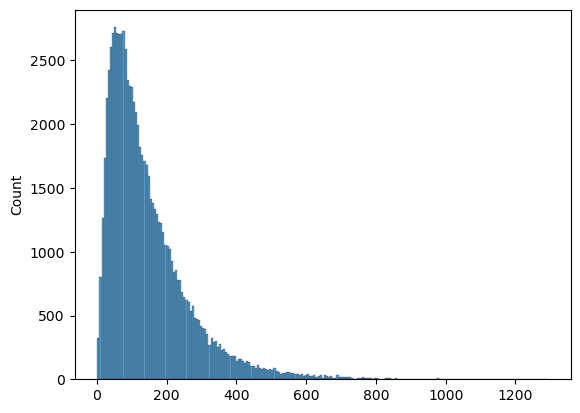

In [20]:
# Plot the length of each review in terms of tokens
doc_lengths = [len(doc) for doc in sample_corpus]
sns.histplot(data=sample_corpus, x=doc_lengths)

In [21]:
print(f"Shortest review: {min(doc_lengths)}\nLargest review: {max(doc_lengths)}\
    \nMean review length: {np.mean(doc_lengths):.4f}\nMedian review length: {np.median(doc_lengths)}")

Shortest review: 1
Largest review: 1294    
Mean review length: 146.7113
Median review length: 114.0


It is possible to see that the vast majority of the reviews are between 0 to 400 tokens in length, with a sizeable minority between 400 and 600. From 600 onwards we have some sparsely distributed reviews. There are many outliers in this area, with the most deviated being a very large (with respect to the other ones) review with 1294 tokens.

The mean review length is approximately 147 but because we know that the mean is susceptible to outliers we also compute the median, which turns out to be 114.

#### 2.1.2 N-grams

More broadly, an *n*-gram is a contiguous sequence of *n* terms from text sample. The *n* prefix denotes the size of the sequence. This notion is specially useful to encapsulate words that have a specific meaning when put together, e.g., *United Kingdom* or *Machine Learning*.

By using `gensim.models.phrases.Phrases` we are able to construct these *n*-grams (we are interested in finding *bigrams* and larger) that meet a certain statistical criteria.

In [22]:
%%time
# Instantiate phrase_model as Phrases object that takes sample_corpus as input
phrase_model = gensim.models.phrases.Phrases(sample_corpus, min_count=2, threshold=30)

# Apply phrase_model and obtain a new list of lists
sample_corpus_phrases = [el for el in phrase_model[sample_corpus]]

# Set review_text column to contain the information
# stored by sample_corpus_phrases
sample_df["review_text"] = sample_corpus_phrases

CPU times: user 31.9 s, sys: 429 ms, total: 32.3 s
Wall time: 32.5 s


In [23]:
%%time
# Save the tokenized and lemmatized dataset with N-grams
#sample_df.to_csv("data/reviews_spoiler_full_n_grams.csv")

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 11.4 µs


### 2.2 Gensim dictionary

#### 2.2.1 Dictionary creation

Gensim's `Dictionary` is tasked with storing the mappings between the normalized words and their IDs, which are integer values.

In [24]:
%%time
# Create dictionary of tokens
D = gensim.corpora.Dictionary(sample_corpus_phrases)

# Obtain the size of the vocabulary contained by the dictionary
n_tokens = len(D)

CPU times: user 8.51 s, sys: 18 ms, total: 8.53 s
Wall time: 8.6 s


In [25]:
print(f"The postive dictionary contains {n_tokens} terms.")

The postive dictionary contains 143989 terms.


In [26]:
print(f"The first twenty terms in the dictionary are:\
\n{[D[i] for i in range(20)]}")

The first twenty terms in the dictionary are:
['accelerator', 'accurate', 'accuse', 'alien', 'alien_civilization', 'answer', 'apart', 'atmosphere', 'band', 'bit', 'blow_mind', 'body', 'book', 'build', 'century', 'chinese', 'civilization', 'collision', 'come', 'cosmic']


`Dictionary` has many useful attributes such as:

* `token2id | dtype=dict(int,int)`: responsible for the reverse mapping `token` -> `token_id`;
* `cfs | dtype=dict(int,int)`: responsible for mapping `token_id` -> `sum([sum(token) for token in document if token == token_id])`
* `dfs | dtype=dict(int,int)`: responsible for mapping `token_id` -> `sum([1 for document in collection for token_i in document if token_i == token_id])`

We now proceed to a more exploratory analysis in order to better understand the data. In order to do so we will be performing some modifications to it.

#### 2.2.2 Further cleaning

In [27]:
%%time
# Create a list of tuples with token and token frequency per document
token_ndocs = [(D[token_id], token_freq) for token_id, token_freq in D.dfs.items()]

CPU times: user 393 ms, sys: 2.04 ms, total: 396 ms
Wall time: 401 ms


In [28]:
%%time
# Create dataframe with two columns from the tuple list
token_df = pd.DataFrame(token_ndocs, columns=["token", "ndocs"])

# Sort dataframe according to column ndocs
token_df = token_df.sort_values(by="ndocs", ascending=False)

CPU times: user 97.2 ms, sys: 124 µs, total: 97.3 ms
Wall time: 96.2 ms


In [29]:
token_df

,token,ndocs
1,book,69857
60,like,61123
20,read,55332
7,love,50363
181,character,49793
...,...,...
99554,marbas,1
99555,coveniently,1
99557,arrrrgggggg,1
99558,eason,1


We can clearly see that there are several tokens that appear exactly in only one document. These tokens are not important for our analysis and may therefore be discarded.

*Did you know?:* In linguistics words that only appear once in a given corpus are called **[hapax legomena](https://en.wikipedia.org/wiki/Hapax_legomenon)** (plural form of the transliteration from the Greek ἅπαξ λεγόμενον).

When referring to two, three or four occurrences we use the forms *dis legomenon*, *tris legomenon*, and *tetrakis legomenon*, respectively (note that the plural form is *legomena*).

In [30]:
# Count the number of tokens that appear exactly once in the entire corpus
n_hapax_legomena = token_df[token_df.ndocs == 1].shape[0]

print(f"Number of hapax legomena: {n_hapax_legomena}")

Number of hapax legomena: 55125


Here we can see that there are several *hapax legomena*. Let's improve this analysis by seeing what is the distribution of tokens with respect to the number of times they appear in the text corpus.

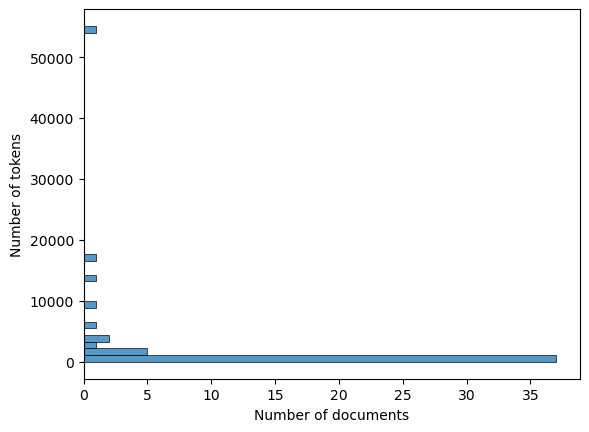

array([    0., 55125., 16563., 14258.,  8869.,  5801.,  4372.,  3326.,
        2687.,  2180.,  1905.,  1533.,  1452.,  1263.,  1084.,   952.,
         815.,   811.,   697.,   641.,   622.,   561.,   506.,   421.,
         440.,   410.,   397.,   366.,   384.,   369.,   333.,   295.,
         274.,   277.,   271.,   240.,   251.,   224.,   214.,   195.,
         197.,   212.,   186.,   187.,   145.,   142.,   156.,   160.,
         162.,   162.])

In [31]:
TOKEN_FREQ_ARRAY_LENGTH = 50

freq_array = np.zeros(TOKEN_FREQ_ARRAY_LENGTH)

for i in range(TOKEN_FREQ_ARRAY_LENGTH):
    # Store token frequencies in corpus
    freq_array[i] = (token_df.ndocs == i).sum()
    #freq_array[i] = token_df[token_df.ndocs == i].shape[0]

# Plot number of words per frequency
sns.histplot(y=freq_array, bins=TOKEN_FREQ_ARRAY_LENGTH)
plt.xlabel("Number of documents") # Number of documents in which a token appears
plt.ylabel("Number of tokens") # Number of tokens that have this frequency
plt.show()

freq_array

It is possible to observe that there are few tokens that appears in a large number of documents, e.g., more than five; whereas there is a large proportion of them that appears in less that five documents (c.f. *hapax legomena* discussed before).

Let's extract now the ten most and least common tokens.

In [32]:
# Obtain the most/least common tokens in terms of document occurance
# this could have been easily done with token_df.head(10) 
# and token_df.tail(10)
lm_common_tokens = [
    token_df.iloc[-10:]["token"],
    token_df.iloc[:10]["token"]
]

print(f"The ten most common tokens are:\n{lm_common_tokens[1]}")
print(f"\nThe ten least common tokens are:\n{lm_common_tokens[0]}")


The ten most common tokens are:
1           book
60          like
20          read
7           love
181    character
44         think
230        story
78          know
147         feel
197         time
Name: token, dtype: object

The ten least common tokens are:
99546          fonder
99548          ladris
99550        wonderer
99551         tararus
99552          sciron
99554          marbas
99555     coveniently
99557     arrrrgggggg
99558           eason
143988    narraration
Name: token, dtype: object


It is known that tokens with very few or very high appeareance frequencies may stymie Natural Processing Language performance. Why? This is because we are unable to extract meaningful patterns across documents using rare words and the converse happens with very common words, they become uninformative as they are present almost anywhere.

There is also the possibility that some of these very strange words are, in fact, just spelling errors as can be seen above (c.f. *coveniently*, *eason* or *narraration*).

In order to do this we will be using `Dictionary`method `filter_extremes`which takes two values as input (lower bound, upper bound).

In [33]:
%%time
# Minimum number of documents that store a given token
MIN_APPEARANCES = 4 # tetrakis legomena

# Maximum proportion of documents that store a given token
MAX_FREQUENCY = .85

# Apply the filter_extremes function
D.filter_extremes(no_below=MIN_APPEARANCES, no_above=MAX_FREQUENCY)
n_tokens = len(D)

print(f"The filtered dictionary contains {n_tokens} terms.\n")

The filtered dictionary contains 58042 terms.

CPU times: user 132 ms, sys: 7.95 ms, total: 140 ms
Wall time: 140 ms


We now save the newly filtered data:

In [34]:
corpus_df = []
for sent in sample_corpus_phrases:
    corpus_df.append([token for token in sent if token in D.token2id.keys()])

sample_df["review_text"] = corpus_df

In [35]:
sample_df

,review_text,rating,book_genre
0,"[special, start, slow, middle, start, interest...",5,fantasy
1,"[fun, fast_pace, science_fiction, thriller, re...",3,thriller
2,"[fun, fast_pace, suck, right, away, let, remna...",4,fantasy
3,"[great, premise, beautifully_write, prose, hac...",3,fantasy
4,"[fun, dark, slightly, comical, western, killer...",3,history
...,...,...,...
81637,"[hot, spell, holly, summer, hooked, start, thi...",4,fantasy
81638,"[end, kind, ruin, thing, thomas, wake, find, n...",3,young_adult
81639,"[miraculously, manage, avoid, spoiler, figure,...",3,thriller
81640,"[read, go, long, installment, selection, let, ...",0,romance


### 2.3 Bag-of-Words (BoW)

**Bag-of-Words (BoW)** is a technique used for text representation simplification in the realm of Natural Language Processing (NLP). The BoW representation consists in storing the number of appearances of each word for each document in the corpus.

The limitations of the BoW representation are clear: it is an extention of the One-Hot Encoding one and it discards grammatical and word order/word position information.

In order to obtain a BoW representation of our corpus we will be using the `doc2bow`provided by Gensim's `Dictionary`. Data is stored in a sparse vector representation with a tuple of `int`s denoting the `token_id` and the other its frequency.

In [36]:
%%time
# Store the BoW representation of all tokens per corpus document
reviews_bow = [D.doc2bow(doc) for doc in corpus_df]

CPU times: user 5.12 s, sys: 257 ms, total: 5.37 s
Wall time: 5.41 s


### 2.4 Term frequency - Inverse document frequency (TF-IDF)

**Term frequency - Inverse document frequency (TF-IDF)** is another technique for text representation simplification for NLP. It takes into account more information and factors than the simpler, BoW transformation.

TF-IDF has the following property: it gives a high value for a term in a given document if that term is common within that document and rare otherwise, i.e., in the rest of the corpus. This means that while BoW is easier to interpret, TF-IDF provides more information about the commnality of certain words and is conditioned by the entire corpus by the IDF.

As expressed previously, TF-IDF is constituted by two different factors: *term frequency* and *inverse document frequency*.

* **Term frequency**: number of time a given word appears in a document.
$$\text{TF}(w, d) = \text{BoW}(w,d)$$

* **Inverse document frequency**: logarithm of the number of documents in the corpus divided by the number of documents with word $w$.
$$\text{IDF}(w) = \text{log}\left(\frac{\#\text{docs}}{\#\text{docs with term } w}\right)$$

So the TF-IDF is given by:
$$\text{TF-IDF} = \text{TF}(w,d) \times \text{IDF}(w)$$

**Note**: Because TF-IDF takes into account the entirety of the corpus in its computations for each element of the document-token matrix is not *not* possible to update it in Gensim's implementation by adding more documents as this would entail a loss of consistency.

In [37]:
%%time
# Build TF-IDF model with Gensim's TfidfModel
tfidf = gensim.models.TfidfModel(reviews_bow)

CPU times: user 1.22 s, sys: 5.75 ms, total: 1.23 s
Wall time: 1.23 s


We can now use `reviews_tfidf`to convert any vector from the BoW representation into the new one, using TF-IDF.

In [38]:
%%time
reviews_tfidf = tfidf[reviews_bow]

CPU times: user 20 µs, sys: 2 µs, total: 22 µs
Wall time: 26 µs


## 3. Word embeddings and Machine Learning Tasks

As we previously saw, both BoW and TF-IDF are quite limited and discard a lot of useful information that would be beneficial for our Machine Learning algorithms.

Then we have the distributional hypothesis which states that words that frequently appear in similar contexts, tend to have similar meaning. This means we can more or less equate *capture meaning* with *capture context* and vice-versa, and this is precisely what we will be doing.

This implies that we have to include the context information into the **word embeddings**, something that neither BoW nor TF-IDF are capable of doing.

**Word embeddings** are the vector representation of words in such a manner that words with similar meaning or characteristics have close representations. Their proximity/closeness is measured by the dot product between the vector forms.

There are three main ways of creating word embeddings:

* **Count-baed methods**: 
* **Prediction-based methods**: e.g., Word2Vec
* **Hybrid methods**: e.g., Glove

### 3.1 Word2Vec

#### 3.1.1 Model creation

In [39]:
#TODO: Añadir explicación de qué es Word2Vec y cómo funciona
#TODO: Añadir también sus ventajas como prediction-based method

There are two Word2Vec variants that are worth mentioning: **Skip-gram** and **CBOW**. They take the opposite approach with respect to each other: **Skip-gram** aims to predict the surronding context word from a central word while **CBOW** aims to predict the central word from the surrounding context.

Both Skip-gram and CBOW are expensive to compute due to softmax normalization; there is a solution, though. It has been checked by Milokov that a selection of 5 to 20 (in small datasets) and of 2 to 5 (in large datasets) may be sufficient to obtain good learning and to capture the relationships between words in a decent manner.

In [40]:
#TODO: Añadir desventajas de Word2Vec

In [41]:
# Define parameters for Word2Vec model

#XXX: How are going to choose vector size & window size?
VECTOR_SIZE = 200
WINDOW_SIZE = 5
SEED_VALUE = 42

In [42]:
%%time
# Create the Word2Vec skip-gram model
# sg=1 --> Skip-gram
# min_count=0 because we have already removed
# rare terms from corpus_df
model_w2v_skip = gensim.models.Word2Vec(
                                            sentences=corpus_df,
                                            vector_size=VECTOR_SIZE,
                                            window=WINDOW_SIZE,
                                            seed=SEED_VALUE,
                                            sg=1,
                                            min_count=0,
                                            workers=os.cpu_count()*2-2
                                        )

#NOTE: Word2Vec has an excellent integration with Gensim Phrases
# but we are not using it as corpus_df has already been transformed
# with all these functions previously.

# Fetch word vectors from the model
wv_w2v_skip = model_w2v_skip.wv

# Free memory from the entire model (we are not going to use it)
del model_w2v_skip

# Save model in file
wv_w2v_skip.save("wordvectors/wv_w2v_skip.wordvectors")


# Load back with memory-mapping = read-only, shared across processes.
wv_skip = gensim.models.KeyedVectors.load("wordvectors/wv_w2v_skip.wordvectors", mmap='r')

CPU times: user 17min 16s, sys: 3.14 s, total: 17min 19s
Wall time: 1min 45s


With Gensim it is easy to obtain the Numpy vector of a given word, for example:

In [43]:
# Obtain Numpy vector of word "comedy"
wv_skip["comedy"]

memmap([ 5.96106350e-01,  3.47928628e-02,  1.41414791e-01,
         1.42999813e-01, -1.78916994e-02, -1.69630706e-01,
         4.94944351e-03,  4.24136370e-01,  2.08575770e-01,
         5.20816386e-01, -2.64445215e-01, -1.22296892e-01,
        -9.92640555e-02, -1.28563708e-02,  7.67957270e-02,
        -3.32315713e-01, -3.48751098e-02, -8.09961706e-02,
        -5.53728789e-02,  2.76846327e-02,  9.94097069e-02,
         2.94971824e-01,  6.67414665e-02,  5.16895056e-01,
         1.08778328e-01,  3.87683600e-01, -2.98858192e-02,
         3.38850766e-01, -7.76629001e-02, -2.72615999e-01,
        -1.84210598e-01, -8.76469887e-04, -5.82865216e-02,
        -1.28994554e-01, -2.48875823e-02, -1.47748932e-01,
         4.15063828e-01, -4.05112714e-01, -2.76537061e-01,
        -2.16734931e-02, -2.80952621e-02, -1.43422723e-01,
         4.85284835e-01,  7.98109621e-02,  1.57489944e-02,
         1.35842085e-01,  1.69442385e-01,  3.25093627e-01,
         1.23361014e-01, -1.83928281e-01, -2.15515152e-0

We can also obtain the most similar words to `comedy` according to the Word2Vec word vector representation.

In [44]:
# Obtain the ten most similar words to "comedy"
wv_skip.most_similar("comedy", topn=10)

[('slapstick', 0.7110525965690613),
 ('humor', 0.6730511784553528),
 ('comedic', 0.6656842827796936),
 ('romantic_comedy', 0.6369540095329285),
 ('hilarity', 0.6354582905769348),
 ('tongue_cheek', 0.6353737711906433),
 ('poke_fun', 0.6207922101020813),
 ('satirical', 0.6204477548599243),
 ('snappy_dialogue', 0.6156452298164368),
 ('chuckle_worthy', 0.6034500002861023)]

We can see that `Word2Vec` model is yielding a pretty good representation of word semantics, for instance, take the example of `comedy` and the ten *closest* words (as computed in terms of vector distances, the similarities); in this we can see that it being associated with words/constructs such as *slapstick*, *comedic*, *tongue_cheek*, *humor*, *campy*, *hilarity*, *humorous*, *chuckle_worthy* and *witticism*. All these words are actually semantically related to `comedy` as we can check in their Merriam-Webster dictionary definitions:

* **[slapstick](https://www.merriam-webster.com/dictionary/slapstick)**: *[...] comedy stressing farce and horseplay.*
* **[campy](https://www.merriam-webster.com/dictionary/campy)**: *[...] in the style of camp : absurdly exaggerated, artificial, or affected in a usually humorous way)*
* **[witticism](https://www.merriam-webster.com/dictionary/witticism)**: derivated from `witty` which in turn reads: *1. marked by or full of clever humor or wit : smartly facetious or jocular a witty novel 2. quick or ready to see or express illuminating or amusing relationships or insights*

#### 3.1.2 Model visualization

To get an idea of the model's performance we can visualize the embeddings. It is not possible to visualize even low-dimensional vectors of four dimensions so we will have to resort to dimensionality reduction if we are to be able to plot the word vectors.

In order to do this we will be employing [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) which stands for *t-distributed Stochastic Neighbor Embedding*. We will be using Sklearn's implementation.

In [45]:
%%time
# Initialize t-SNE
with parallel_backend("threading", n_jobs=os.cpu_count()*2-2):
    t_sne = TSNE(init="pca")
    wv_skip_tsne = t_sne.fit_transform(wv_skip.vectors)


CPU times: user 40min 36s, sys: 1min 24s, total: 42min
Wall time: 7min 8s


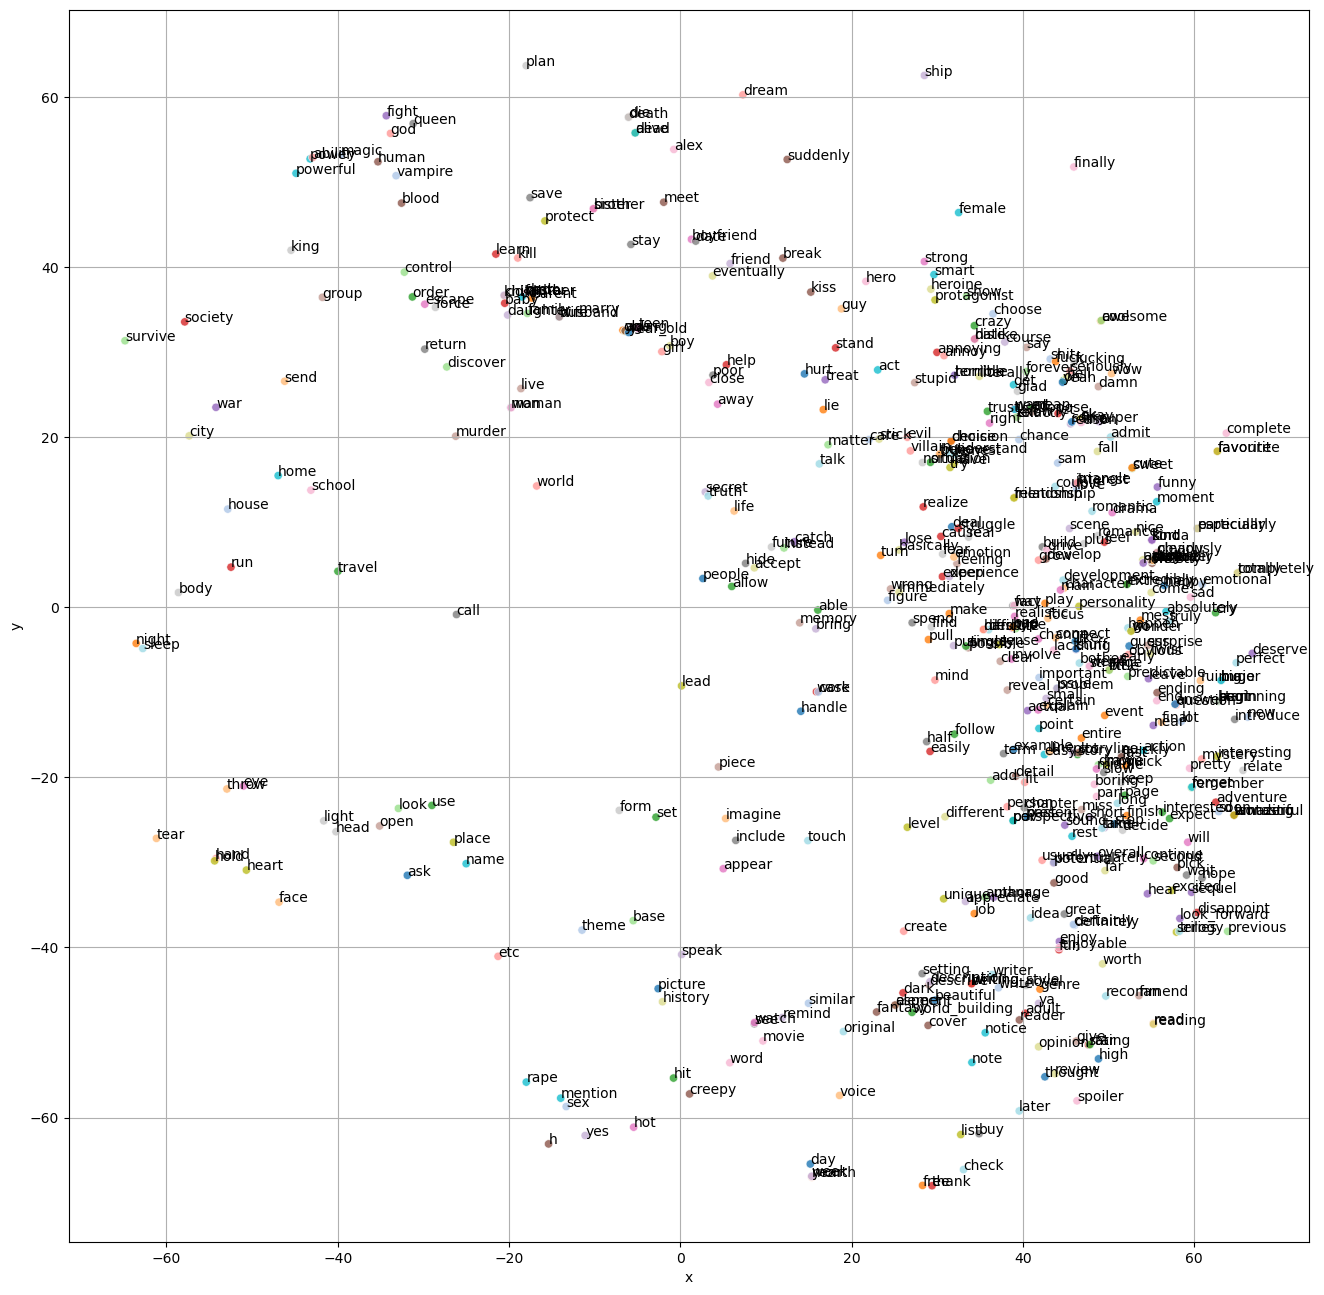

CPU times: user 3.18 s, sys: 258 ms, total: 3.44 s
Wall time: 2.45 s


In [46]:
%%time
# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))

# create a DataFrame to store the embeddings
df = pd.DataFrame(wv_skip_tsne[:500], columns=['x', 'y'])
df['word'] = list(wv_skip.key_to_index.keys())[:500]

# plot the embeddings using seaborn scatterplot
sns.scatterplot(data=df, x='x', y='y', hue="word", palette="tab20", alpha=.8, legend=False)

# add annotations for the words
for row in df.itertuples():
    plt.annotate(row.word, xy=(row.x, row.y), fontsize=10)

plt.grid()
plt.show()


We can see in this plot that the 2-dimensional `t-SNE` with random initialization is capturing and expressing some word semantincs. For example, look for the closeness in the representation of the words `rape` with `sex`, `king` with `queen`, `blood` with `vampire`, `build` with `grow`, among many others. Obviously, coming from a much higher dimensional space the interpretability of these two dimensions is more convoluted but it is nonetheless useful in checking whether the word embedding representation is any good.

In [47]:
# Free the memory allocated to wv_skip_tsne
del wv_skip_tsne

#### 3.1.3 Sentence embeddings

Notice that our data analysis is concerned not just with the vector representation of mere words but that of entire sentences: the reviews.

A straightforward mechanism to compute the review embeddings is to take the average of all words vector, i.e., compute the mean of all the word vectors belonging to a review.

Because we had already removed rare and very common terms from `corpus_df` we set `min_count = 0` in Word2Vec and that is why we need not to compute the ratio of covered words (it is 1.0) as there is no OOV (Out-of-bag vocabulary). This can be seen using the `get_vocabulary_coverage` function defined below:

In [48]:
def get_vocabulary_coverage(model, gensim_dict):
    # Count the total number of words
    total_words = sum(gensim_dict.dfs.values())

    # Create counters to store the number of words
    # belonging to each type
    covered_words = 0
    oov_words = 0

    # Iterate over the words in the dictionary
    for word, freq in gensim_dict.dfs.items():
        # Check whether a word is also in the vocabulary
        # of the Word2Vec model
        if word in model:
            covered_words += freq
        else:
            oov_words += freq

    # Calculate the coverage
    coverage = covered_words / total_words

    return coverage

In [49]:
%%time
wv_coverage = get_vocabulary_coverage(wv_skip, D)

print(f"The ratio of covered words is {wv_coverage}\n")

The ratio of covered words is 1.0

CPU times: user 60.1 ms, sys: 1.93 ms, total: 62 ms
Wall time: 60.5 ms


As mentioned before, what we need are not so much the individual word vectors but the review vectors if we are to apply a Machine Learning (ML) algorithm so we are going to define the function `get_review_vector` to return the sentence embedding by averaging the individuals word vectors.

In [50]:
def get_review_vector(model, review):
    # We initialize the review vector with all zeros
    vec = np.zeros(model.vector_size)
    # We initialize the counter to count the number of
    # words that are present in a given review
    n_words = 0

    for token in review:
        # Check whether the token is covered
        # in the w2v_model (take) or not (discard)
        if token in model:
            vec += model[token]
            n_words += 1
        else:
            print("\n[OOV] This is not supposed to happen.\n")

    if n_words > 0:
        vec /= n_words  # Take the average
    else:
        print("\n[NO COVERAGE] This is not supposed to happen.\n")  # We have the all zeros vector

    return vec

In [51]:
%%time
# Create a list of review vectors by taking the average of word vectors
review_vectors = [get_review_vector(wv_skip, review_tokens) for review_tokens in corpus_df]

# We check that the length of review_vectors matches
# the number of reviews
print(len(review_vectors))

81642
CPU times: user 1min 1s, sys: 147 ms, total: 1min 2s
Wall time: 1min 2s


#### 3.1.3 Regression using Word2Vec embeddings

We are performing here regression with SVRs using Word2Vec embeddings in a *tentative* manner, to later **compare** the performance of these models with this information versus that of the models trained with the LDA preprocessing step.

##### 3.1.3.1 SVR using cuML/RAPIDS

In [ ]:
%%time
X_gpu = cudf.DataFrame(review_vectors)
y_gpu = cudf.Series(sample_df["rating"].values.ravel())

# Split the data into training and test sets
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = cuml.model_selection.train_test_split(X_gpu, y_gpu, test_size=.3, random_state=42)

In [ ]:
%%time
# Define the hyperparameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1.0, 5, 10.0],
              "epsilon": [0.01, 0.1, 1.0],
              "kernel": ["linear", "rbf", "poly"],
              "degree": [2, 3, 4]}

# Define the SVR model
svr_gpu = cuml.svm.SVR(output_type="numpy")

# Define the grid search with cross-validation
grid_search_gpu = cuml.model_selection.GridSearchCV(estimator=svr_gpu,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

# Fit the grid search to the training data
grid_search_gpu.fit(X_train_gpu, y_train_gpu)

In [ ]:
# Print the best hyperparameters and mean 5-fold CV score
print("Best hyperparameters: ", grid_search_gpu.best_params_)
print("Best mean cross-validation score: ", -grid_search_gpu.best_score_)

In [ ]:
# Train the final SVR model on the training data with the best hyperparameters
svr_best = cuml.svm.SVR(C=grid_search_gpu.best_params_['C'],
                        epsilon=grid_search_gpu.best_params_["epsilon"],
                        kernel=grid_search_gpu.best_params_["kernel"],
                        degree=grid_search_gpu.best_params_["degree"])

# Fit the model using the best parameters according to 5-fold CV
svr_best.fit(X_train_gpu, y_train_gpu)

# Evaluate the final model on the test set
y_pred_gpu = svr_best.predict(X_test_gpu).get()
mse_gpu = mean_squared_error(y_test_gpu, y_pred_gpu)
print(f"Mean squared error on test set: {mse_gpu}")


In [ ]:
# Serialize/save best SVR model obtained using cuML
pickle.dump(model, open("models/wv_skip_best_svr_gpu.pkl", "wb"))

##### 3.1.3.2 SVR using Scikit-learn

In [ ]:
%%time
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(review_vectors, sample_df["rating"], test_size=.3, random_state=42)

In [ ]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Define the SVM regressor
    svm = SVR()

param_grid = {'C': [0.01, 0.1, 1.0, 5, 10.0],
              "epsilon": [0.01, 0.1, 1.0],
              "kernel": ["linear", "rbf", "poly"],
              "degree": [2, 3, 4]}

    # Perform grid search #TODO with cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

In [ ]:
# Get the best hyperparameter values from the grid search
best_C = grid_search.best_params_['C']
best_kernel = grid_search.best_params_["kernel"]

# Print best values
print(f"Best C value is {best_C}\nBest kernel choice is {best_kernel}")

In [ ]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Train an SVM regressor with the best hyperparameters
    svm_best = SVR(C=best_C, kernel=best_kernel)
    svm_best.fit(X_train, y_train)

In [ ]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Predict the labels for the test data
    y_pred = svm_best.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False) # RMSE

In [ ]:
rmse

In [ ]:
# Serialize/save best model obtained using scikit-learn
pickle.dump(model, open("models/wv_skip_best_svr_skl.pkl", "wb"))

#### 3.1.4 Classification using Word2Vec embeddings

In [ ]:
%%time
sample_df_cat = pd.DataFrame()
# Convert "rating" column to category data type
sample_df_cat["rating"] = sample_df["rating"].astype("category")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(review_vectors, sample_df_cat["rating"], test_size=.3, random_state=42)

In [ ]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Define the SVM regressor
    svm = SVC()

    # Define the hyperparameter grid for grid search
    param_grid = {'C': [1, 3, 5, 7, 9], "kernel": ["rbf", "linear"]}

    # Perform grid search #TODO with cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

In [ ]:
# Get the best hyperparameter values from the grid search
best_C = grid_search.best_params_['C']
best_kernel = grid_search.best_params_["kernel"]

# Print best values
print(f"Best C value is {best_C}\nBest kernel choice is {best_kernel}")

In [ ]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Train an SVM regressor with the best hyperparameters
    svm_best = SVC(C=best_C, kernel=best_kernel)
    svm_best.fit(X_train, y_train)

In [ ]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Predict the labels for the test data
    y_pred = svm_best.predict(X_test)
    accuracy = accuracy_score(y_test.astype("float64"), y_pred)

In [ ]:
accuracy

### 3.2 Glove

#TODO

### 3.3 FastText

#TODO

## 4. Topic modelling

### 4.1 Latent Semantic Indexing (LSI)

#TODO

### 4.2 Latent Direchlet Allocation (LDA)

#TODO (we will be using Gensim, not Mallet)

## 5. Dash

#TODO